<a href="https://colab.research.google.com/github/Kamilr616/Emotion_sentiment_analysis/blob/develop/source/colab/Emotion_Sentiment_Analysis_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies


In [1]:
!pip install tensorflow pandas scikit-learn kaggle seaborn nltk numpy


# Import libaries

In [54]:
import pandas as pd
import tensorflow as tf
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np

# Upload config files

In [3]:
os.makedirs('datasets', exist_ok=True)
files.upload()

Saving datasets.txt to datasets.txt
Saving datasets_source.txt to datasets_source.txt
Saving kaggle.json to kaggle.json


{'datasets.txt': b'#tweet_emotions.csv\r\nEmotion_classify_Data.csv\r\nemotion_sentimen_dataset.csv\r\ntext.csv\r\n',
 'datasets_source.txt': b'simaanjali/emotion-analysis-based-on-text\r\nshreejitcheela/text-emotion-recognition\r\npashupatigupta/emotion-detection-from-text\r\nnelgiriyewithana/emotions\r\nabdallahwagih/emotion-dataset\r\n',
 'kaggle.json': b'{"username":"kamilrataj","key":"c4a9a70b3990f45a4bf249bfe5bada5a"}'}

# Initialize Kaggle API

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kaggle

# Fetch datasets from Kaggle

In [5]:
def download_kaggle_datasets(dataset_list):
    """
    Download each dataset specified in the list from Kaggle using the Kaggle API.

    Args:
    dataset_list (str): Path to a file containing a list of dataset identifiers on Kaggle.
    """
    try:
        with open(dataset_list, 'r') as file:
            for line in file:
                line = line.strip()
                if line:  # Ensures that blank lines are skipped
                    try:
                        kaggle.api.dataset_download_files(line, path='datasets/', unzip=True)
                        print(f"Successfully downloaded {line}")
                    except Exception as e:
                        print(f"Failed to load {line}: {e}")
    except FileNotFoundError:
        print(f"File {dataset_list} not found.")
    except Exception as e:
        print(f"An error occurred while reading {dataset_list}: {e}")

download_kaggle_datasets('datasets_source.txt')

Dataset URL: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text
Successfully downloaded simaanjali/emotion-analysis-based-on-text
Dataset URL: https://www.kaggle.com/datasets/shreejitcheela/text-emotion-recognition
Successfully downloaded shreejitcheela/text-emotion-recognition
Dataset URL: https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text
Successfully downloaded pashupatigupta/emotion-detection-from-text
Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
Successfully downloaded nelgiriyewithana/emotions
Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset
Successfully downloaded abdallahwagih/emotion-dataset


# Load datasets to dataframes list

In [6]:
def load_datasets_from_file(filename):
    """
    Reads filenames from a text file, each pointing to a dataset.
    Each dataset is loaded into a pandas DataFrame and all DataFrames
    are returned in a list.

    Args:
    filename (str): The path to the text file containing dataset paths.

    Returns:
    list of pd.DataFrame: A list containing all the DataFrames loaded.
    """
    dataframes = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line:  # Ensures that blank lines are skipped
                  if line[0] == '#':
                    continue
                  else:
                      try:
                          # Load the dataset into a DataFrame
                          line = f"datasets/{line}"
                          dframe = pd.read_csv(line)
                          dataframes.append(dframe)
                      except Exception as e:
                          print(f"Failed to load {line}: {e}")
    except FileNotFoundError:
        print(f"File {filename} not found.")
    except Exception as e:
        print(f"An error occurred while reading {filename}: {e}")

    return dataframes


df_loaded_list = load_datasets_from_file('datasets.txt')
df_loaded_list

[                                                Comment Emotion
 0     i seriously hate one subject to death but now ...    fear
 1                    im so full of life i feel appalled   anger
 2     i sit here to write i start to dig out my feel...    fear
 3     ive been really angry with r and i feel like a...     joy
 4     i feel suspicious if there is no one outside l...    fear
 ...                                                 ...     ...
 5932                 i begun to feel distressed for you    fear
 5933  i left feeling annoyed and angry thinking that...   anger
 5934  i were to ever get married i d have everything...     joy
 5935  i feel reluctant in applying there because i w...    fear
 5936  i just wanted to apologize to you because i fe...   anger
 
 [5937 rows x 2 columns],
         Unnamed: 0                                               text  Emotion
 0                0  i seriously hate one subject to death but now ...     hate
 1                1             

# Standardize column names

In [7]:
# Function to rename columns based on mapping
def standardize_column_names(frame, column_map):
    # Convert all column names to lowercase
    frame.columns = map(str.lower, frame.columns)

    # Create a reverse mapping where each synonym maps to the standard name
    reverse_mapping = {synonym: standard for standard, synonyms in column_map.items() for synonym in synonyms}

    # Rename the columns in the DataFrame
    for old_name, new_name in reverse_mapping.items():
        if old_name in frame.columns:
            frame.rename(columns={old_name: new_name}, inplace=True)

    return frame

column_mapping = {
    'text': ['text', 'content', "comment"],
    'emotion': ['emotion', 'label', 'sentiment']
}

df_std_list = []

for _df in df_loaded_list:
  df_std_list.append(standardize_column_names(_df, column_mapping))


df_std_list

[                                                   text emotion
 0     i seriously hate one subject to death but now ...    fear
 1                    im so full of life i feel appalled   anger
 2     i sit here to write i start to dig out my feel...    fear
 3     ive been really angry with r and i feel like a...     joy
 4     i feel suspicious if there is no one outside l...    fear
 ...                                                 ...     ...
 5932                 i begun to feel distressed for you    fear
 5933  i left feeling annoyed and angry thinking that...   anger
 5934  i were to ever get married i d have everything...     joy
 5935  i feel reluctant in applying there because i w...    fear
 5936  i just wanted to apologize to you because i fe...   anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     hate
 1                1             

#Standardize labels

In [8]:
def standardize_emotion_names(dataframe, emotion_dict):
    """
    Standardize the names of emotions in a DataFrame.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing emotion labels.
    emotion_dict (dict): A dictionary mapping original emotion names to standardized names.

    Returns:
    pd.DataFrame: The DataFrame with standardized emotion names.
    """
    reverse_emotion_dict = {synonym: emotion for emotion, synonyms in emotion_dict.items() for synonym in synonyms}
    dataframe['emotion'] = dataframe['emotion'].replace(reverse_emotion_dict)
    return dataframe


emotions_dictionary = {
    'sadness': ['sad', 'sadness', 'depressed', 0],
    'happiness': ['happy', 'happiness', 'joy', 1],
    'neutral': ['neutral', 'indifferent', 'unbiased'],
    'worry': ['worry', 'anxiety', 'concern'],
    'surprise': ['surprise', 'astonishment', 'shock', 5],
    'love': ['love', 'affection', 'adoration', 2],
    'anger': ['angry', 'rage', 'outrage', 'anger', 3],
    'relief': ['relief', 'ease', 'comfort'],
    'fear': ['fear', 'dread', 'terror', 4],
    'empty': ['empty', 'void', 'hollow'],
    'fun': ['fun', 'joyful', 'amusing'],
    'hate': ['hate', 'detest', 'loathe'],
    'enthusiasm': ['enthusiastic', 'excited', 'eager'],
    'boredom': ['boredom', 'tedium', 'monotony']
}

df_std_list_2 = []

for _df in df_std_list:
  df_std_list_2.append(standardize_emotion_names(_df, emotions_dictionary))

df_std_list_2


[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

#Check and drop NULL records

In [9]:
df_std_list_3 = []

for _df in df_std_list_2:
  df_std_list_3.append(_df.dropna())
  print(_df.isnull().any())

text       False
emotion    False
dtype: bool
unnamed: 0    False
text          False
emotion       False
dtype: bool
unnamed: 0    False
text          False
emotion       False
dtype: bool


#Cleaning records

In [10]:
# Function to remove user mentions, links, and unnecessary characters
def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove user mentions
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove links
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove non-alphanumeric characters
    return text

df_clean_list = []

for _df in df_std_list_3:
  _df['text'] = _df['text'].apply(clean_text)
  df_clean_list.append(_df)

df_clean_list

[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

# Chat words mapping

In [11]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}


# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df_clean_list_2 = []

for _df in df_clean_list:
  _df['text'] = _df['text'].apply(replace_chat_words)
  df_clean_list_2.append(_df)

df_clean_list_2


[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

# Stopwords

In [12]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

df_words_list = []

for _df in df_clean_list_2:
  _df["text"] = _df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  df_words_list.append(_df)

df_words_list


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[                                                   text    emotion
 0     seriously hate one subject death feel reluctan...       fear
 1                            im full life feel appalled      anger
 2     sit write start dig feelings think afraid acce...       fear
 3     ive really angry r feel like idiot trusting fi...  happiness
 4     feel suspicious one outside like rapture happe...       fear
 ...                                                 ...        ...
 5932                              begun feel distressed       fear
 5933  left feeling annoyed angry thinking center stu...      anger
 5934  ever get married everything ready offer got to...  happiness
 5935  feel reluctant applying want able find company...       fear
 5936         wanted apologize feel like heartless bitch      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  seriously hate one subject death feel reluctan...     h

#Stemming (whitespace)

In [13]:
df_stemmed_list = []

for _df in df_clean_list:
  _df['text'] = _df['text'].str.replace(r'\s+', ' ', regex=True)
  df_stemmed_list.append(_df)

df_stemmed_list

[                                                   text    emotion
 0     seriously hate one subject death feel reluctan...       fear
 1                            im full life feel appalled      anger
 2     sit write start dig feelings think afraid acce...       fear
 3     ive really angry r feel like idiot trusting fi...  happiness
 4     feel suspicious one outside like rapture happe...       fear
 ...                                                 ...        ...
 5932                              begun feel distressed       fear
 5933  left feeling annoyed angry thinking center stu...      anger
 5934  ever get married everything ready offer got to...  happiness
 5935  feel reluctant applying want able find company...       fear
 5936         wanted apologize feel like heartless bitch      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  seriously hate one subject death feel reluctan...     h

# Merge dataframes

In [14]:
def concat_dataframes(dataframes):
    """
    Concatenate a list of DataFrames into a single DataFrame.

    Args:
    dataframes (list of pd.DataFrame): A list of DataFrames to concatenate.

    Returns:
    pd.DataFrame: A single DataFrame containing all the data from the input DataFrames.
    """
    final_dataset = []

    for df in dataframes:
        final_dataset.append(df[['text', 'emotion']])

    return pd.concat(final_dataset, ignore_index=True)


df_merged = concat_dataframes(df_stemmed_list)
df_merged

,text,emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,happiness
4,feel suspicious one outside like rapture happe...,fear
...,...,...
1262296,feel like telling horny devils find site suite...,love
1262297,began realize feeling agitated restless would ...,anger
1262298,feel curious previous early dawn time seek tro...,surprise
1262299,feel becuase tyranical nature government el sa...,anger


# Drop duplicates

In [15]:
df_uniqe = df_merged.drop_duplicates(subset=['text'])
num_unique_records = len(df_uniqe)

print(f'Number of unique records: {num_unique_records}')
df_uniqe

Number of unique records: 382153


,text,emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,happiness
4,feel suspicious one outside like rapture happe...,fear
...,...,...
428677,cry feel sense loss patients die helped die di...,neutral
428678,feel like telling horny devils find site suite...,neutral
428680,feel curious previous early dawn time seek tro...,neutral
428681,feel becuase tyranical nature government el sa...,neutral


# Drop unnessesary columns

In [16]:
df_uniqe = df_uniqe[['text', 'emotion']]
df_uniqe.shape

(382153, 2)

#Shuffling records

In [17]:
# Shuffle the DataFrame records
df_shuffled = df_uniqe.sample(frac=1).reset_index(drop=True)
df_shuffled

,text,emotion
0,feel like havent missed beat,neutral
1,still feel hesitant bit nervous try work build...,neutral
2,feel going numb,neutral
3,feeling terribly horny need friend even,neutral
4,heard bits pieces seemed indicate dealt breaku...,neutral
...,...,...
382148,feel works well force stop working one point t...,neutral
382149,feel terribly punished alone,neutral
382150,trying evoke feelings calm client feel like sh...,fun
382151,feel athletes feel whose freedom taken away ho...,neutral


# Describe and check dataset

In [18]:
df_shuffled.describe()

,text,emotion
count,382153,382153
unique,382153,14
top,feel still havent accepted even time label chr...,neutral
freq,1,301536


#Visualize content

In [19]:
df_shuffled['emotion'].value_counts()

emotion
neutral       301536
love           17291
happiness      14641
sadness         8248
relief          7735
anger           7716
hate            5911
fun             4704
enthusiasm      4366
surprise        3371
empty           2622
worry           2027
fear            1924
boredom           61
Name: count, dtype: int64

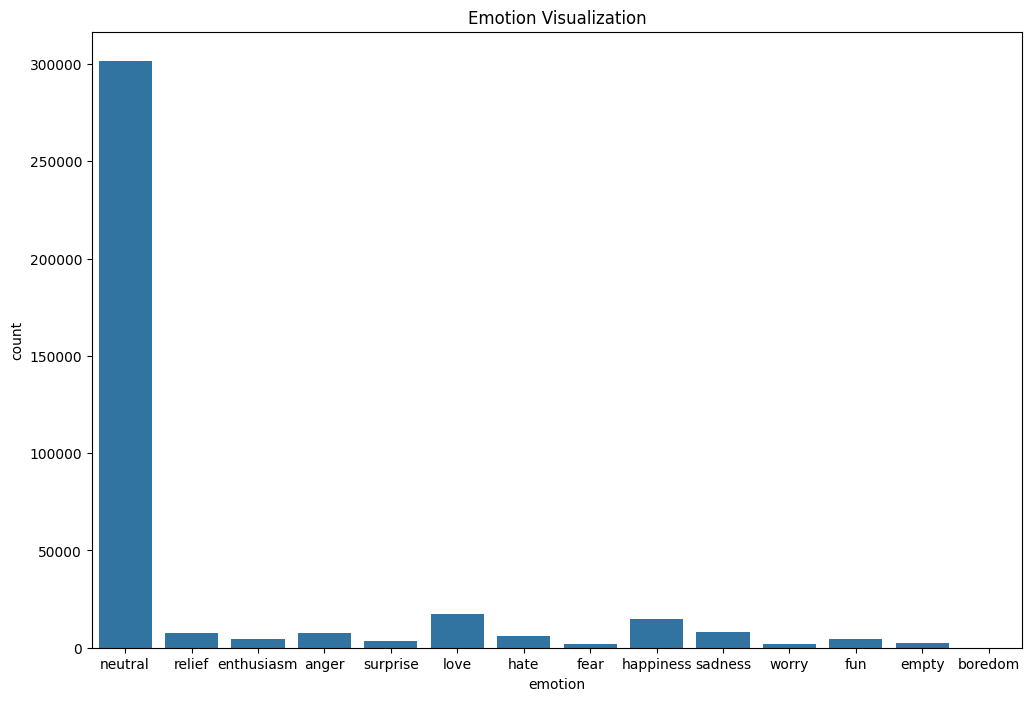

In [20]:
plt.figure(figsize=(12, 8))
sns.countplot(x='emotion', data=df_shuffled)
plt.title('Emotion Visualization')
plt.show()

#Label Encoding

In [21]:
texts = df_shuffled['text'].values
labels = df_shuffled['emotion'].values

# Konwersja etykiet do wartości liczbowych
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Tokenization

In [22]:
tokenizer = Tokenizer(num_words=60000, lower=True)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

# Traning Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

#Create and compile Model

In [56]:
# Budowa modelu
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=100))
model.add(SpatialDropout1D(0.2))

# Bidirectional LSTM layer
model.add(Bidirectional(CuDNNLSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          7513800   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               235520    
 onal)                                                           
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

# Train and evaluate model

In [ ]:
# Trening modelu
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Ewaluacja modelu
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss * 100:.2f}%')

Epoch 1/10
4180/4180 - 111s - loss: 0.2095 - accuracy: 0.9610 - val_loss: 1.9377 - val_accuracy: 0.1442 - 111s/epoch - 26ms/step
Epoch 2/10
4180/4180 - 87s - loss: 0.0990 - accuracy: 0.9815 - val_loss: 0.1350 - val_accuracy: 0.9797 - 87s/epoch - 21ms/step
Epoch 3/10
4180/4180 - 86s - loss: 0.0797 - accuracy: 0.9835 - val_loss: 0.1115 - val_accuracy: 0.9828 - 86s/epoch - 21ms/step
Epoch 4/10
4180/4180 - 75s - loss: 0.0671 - accuracy: 0.9846 - val_loss: 0.1116 - val_accuracy: 0.9816 - 75s/epoch - 18ms/step
Epoch 5/10
4180/4180 - 77s - loss: 0.0582 - accuracy: 0.9861 - val_loss: 0.1199 - val_accuracy: 0.9818 - 77s/epoch - 18ms/step
Epoch 6/10
4180/4180 - 74s - loss: 0.0511 - accuracy: 0.9874 - val_loss: 0.1338 - val_accuracy: 0.9802 - 74s/epoch - 18ms/step
Epoch 7/10
4180/4180 - 76s - loss: 0.0462 - accuracy: 0.9883 - val_loss: 0.1336 - val_accuracy: 0.9800 - 76s/epoch - 18ms/step
Epoch 8/10
4180/4180 - 75s - loss: 0.0422 - accuracy: 0.9891 - val_loss: 0.1471 - val_accuracy: 0.9781 - 75s/

#Classification report

In [44]:
# Predict classes
y_pred = model.predict(X_test)

# Convert predicted probabilities to class indices
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to single labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate and print accuracy
accuracy2 = accuracy_score(y_test_labels, y_pred_labels)
print(f'Accuracy: {accuracy2 * 100:.2f}%')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Accuracy: 97.09%
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1520
           1       0.92      1.00      0.96        12
           2       0.98      0.99      0.99       528
           3       0.98      1.00      0.99       855
           4       0.04      0.03      0.04       386
           5       0.98      0.99      0.99       942
           6       0.84      0.86      0.85      2857
           7       0.98      0.99      0.98      1154
           8       0.99      0.99      0.99      3462
           9       0.98      0.98      0.98     60374
          10       0.98      0.99      0.98      1560
          11       0.99      0.99      0.99      1701
          12       1.00      1.00      1.00       666
          13       0.96      1.00      0.98       414

    accuracy                           0.97     76431
   macro avg       0.89      0.90      0.89     76431
weighted avg       0.97      0.97      0

# Save model file

In [43]:
# Zapisanie modelu do pliku
model.save('emotion_classification_model.h5')
print("Model saved to emotion_classification_model.h5")

Model saved to emotion_classification_model.h5


#Testing model on input data

In [52]:
# Predykcja dla nowych tekstów
new_texts = ["The sun is shining and everything seems possible today!",
            "I can't believe I just won the lottery.",
            "It feels like I'm carrying the weight of the world on my shoulders.",
            "My heart is pounding, and my hands are shaking uncontrollably.",
            "I do not think that is a good idea.",
            "The project deadline is approaching, and I haven't even started yet."
            ]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=100)
predictions = model.predict(new_padded_sequences)

# Wyświetlenie wyników predykcji
for i, prediction in enumerate(predictions):
    predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]
    print(f'Text: {new_texts[i]} - Predicted Emotion: {predicted_label}')

1/1 [==============================] - 0s 32ms/step
Text: The sun is shining and everything seems possible today! - Predicted Emotion: neutral
Text: I can't believe I just won the lottery. - Predicted Emotion: anger
Text: It feels like I'm carrying the weight of the world on my shoulders. - Predicted Emotion: neutral
Text: My heart is pounding, and my hands are shaking uncontrollably. - Predicted Emotion: neutral
Text: I do not think that is a good idea. - Predicted Emotion: neutral
Text: The project deadline is approaching, and I haven't even started yet. - Predicted Emotion: neutral
